For $N_i$ fixed ions of charge $+Ze$ and $N_e$ electrons of charge $-e$ travelling in random directions at speed $v$, accelerating electrons emit isotropically.
$$\frac{\epsilon_{\nu}}{4\pi} = \frac{8 Z^2 e^6}{3m^2 v c^3}N_i N_e \frac{\pi}{\sqrt{3}}g_{ff}$$

Since unbound, use an analogous quantum number $\eta$ such that the initial state $E_i = Z^2 I_0 / \eta^2$ and the final energy state is $E_f = Z^2 I_0 / \eta'^2$, for $I_0 = m e^4 / (2\hbar)^2$. With manipulation, $\eta = Z \alpha / \beta$ and $\eta' = Z \alpha / \sqrt{\beta^2 + 2 \alpha^2 E_f}$ with corresponding wavenumbers.

Quantum Woo $\rightarrow$ analytical continuation garbage that doesn't really matter understand $g_{ff}$, which is a ratio of the QM cross-section and the semi-classical derived cross-section.

$$g_{ff} =\frac{2\sqrt{3}}{\pi \eta_i \eta_f}[(\eta_i^2 + \eta_f^2 + 2\eta_i^2\eta_f^2)I_0 - 2\eta_i\eta_f(1+\eta_i^2)^{1/2}(1+\eta_f^2)^{1/2}I_1]I_0$$
Where $I_l$ has some functional form.

In [229]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from mpmath import hyp2f1, factorial, gamma
fsc = constants.alpha   
aB_in_cm = constants.value('Bohr radius') * 1e2
c = constants.c * 1.e2
e_e = 4.80320451e-10
m_e = constants.electron_mass * 1e3
k = 1.380648780669e-16

In [230]:
def I(eta_i, eta_f, k_i, k_f, l):
    """something dumb (radial-dipole integral)
    
    Arguments:
    eta_i  : modified quantum number associated with initial energy
    eta_f  : modified quantum number associated with final energy
    k_i    : wavenumber associated with initial energy
    k_f    : wavenumber associated with final energy
    l      : azimuthal quantum number
    
    Returns:
    I_l    : some number.
    """
    temp1 = 1/4*(4.* k_i * k_f / (k_i - k_f)**2)**(l+1) 
    temp2 = np.exp(np.pi/2*abs(eta_i - eta_f))
    temp3 = abs(gamma(l+1+1j*eta_i) * gamma(l+1+1j*eta_f)) / gamma(2.*l + 2)
    return temp1 * temp2 * temp3 *G(eta_i, eta_f, k_i, k_f, l)

def G(eta_i, eta_f, k_i, k_f, l):
    """something dumb helper"""
    temp1 = abs((k_f - k_i) / (k_f + k_i))**(1j*eta_i + 1j*eta_f)
    temp2 = hyp2f1(l+1-1j*eta_f, 
                   l+1-1j*eta_i, 
                   2.*l+2, 
                   -4.*k_i*k_f/(k_i-k_f)**2)

    return (temp1 * temp2).real

In [231]:
def gaunt_free_free(Z, beta, E):
    """calculate the Gaunt factor for free-free emission
    
    Arguments:
    Z    : ion charge, int
    beta : velocity of incident electron in units of c, float or array
    E    : energy of photon in units of Ha, float or array
    
    Returns:
    g_ff : gaunt factor for free-free emission"""
    
    eta_i = Z * fsc / beta
    k_i = Z / eta_i / aB_in_cm
    eta_f = Z * fsc / (beta**2 + 2*E*fsc**2)**.5
    k_f = Z / eta_f / aB_in_cm

    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)
    
    out = 2*3**.5/np.pi/eta_i/eta_f * I0
    out *=((eta_i**2 + eta_f**2 + 2*eta_i**2*eta_f**2)*I0 - 2 * eta_i * eta_f * (1 + eta_i**2)**.5*(1+eta_f**2)**.5*I1)

    return out.real

In [232]:
def free_free_emission_spectrum(Z, hnu, E):
    """calculate free-free spectrum
    
    Arguments:
    Z    : ion charge, int
    hnu  : energy of emitted photon, in Ha
    E    : electron final energy, in Ha"""
    if hnu >= E:
        return 0.
    g_ff = gaunt_free_free(Z, fsc * (2*(E - hnu))**.5, hnu)
    return 64 * np.pi**2 / 3 / 3**.5 * Z**2 * fsc**3 / (2*E)**.5 * g_ff

The free-free emission per unit volume of a thermal gas is obtained averaging over a Maxwellian distribution, $f(E) \propto \sqrt{E} exp(-E/T)$

In [233]:
def free_free_thermal_spectrum(Z, T, E):
    """calculate free-free spectrum
    from an ensemble of electrons following a Maxwellian
    
    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in Ha
    E    : energies of emitted photons, in Ha
    """
    out = np.zeros_like(E)
    for i, hnu in enumerate(E):
        out[i] = scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T) * free_free_emission_spectrum(Z, hnu, x), hnu, np.inf)[0]
        out[i] /= scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T), 0, np.inf)[0]
    return out

Emissivity $\epsilon_{\nu}$ of free-free emission from an ensemble of electrons therefore is proportional to the velocitiy weighted Gaunt factor.
$$\epsilon_{\nu,ff} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 \sqrt{3} m^2 c^3}N_i N_e \frac{\int_{h\nu}^{\infty}g(E, \nu) e^{-E / k T} dE}{\int_{0}^{\infty}\sqrt{E} e^{-E / k T} dE} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 m c^3}N_i N_e \bigg(\frac{2\pi}{3 k T m}\bigg)^{1/2} e^{-h \nu / k T} \bar{g}_{ff}$$

I am putting emissivity in cgs units.

In [234]:
def emissivity_free_free(Z, Ni, Ne, T, nu):
    """calculate emissivity of free free emission
    
    Arguments:
    Z    : ion charge, int
    Ni   : ion density, in cm^-3
    Ne   : electron density, in cm^-3
    T    : temperature of electrons, in K
    nu   : frequency, in Hz
    """
    T_Ha = T * 3.16680853419133e-6
    hnu_Ha = nu * 1.519828500715e-16
    
    term = scipy.integrate.quad(lambda x:np.exp(-x/T_Ha) * gaunt_free_free(Z, fsc*(2*(x-hnu_Ha))**.5, hnu_Ha), hnu_Ha, np.inf)[0]
    term /= scipy.integrate.quad(lambda x: x**.5 * np.exp(-x/T_Ha), 0, np.inf)[0]
    # the exponential is folded into the numerator
    
    prefactor = 2**5 * np.pi * Z**2 * e_e**6 / 3 / m_e / c**3
    temp2 = (2 * np.pi / 3 /k/m_e/T)**.5
    return Ni*Ne*prefactor*temp2*term

In [235]:
test = []
for nu in np.logspace(np.log10(3e13),np.log10(3e15),20):
    test.append(nu * emissivity_free_free(1, 1, 1, 10000, nu))

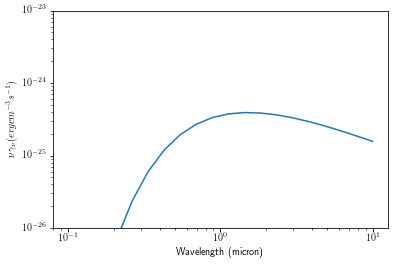

In [237]:
plt.loglog(3e14/np.logspace(np.log10(3e13),np.log10(3e15),20), np.array(test))
plt.ylim(1e-26,1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [216]:
Z = 1.0
energies = np.logspace(-5,8,101) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 15) # Ry

gff1 = [[gaunt_free_free(Z, v, photon_energy) for v in velocities] for photon_energy in photon_energies]


(1e-05, 10000000.0)

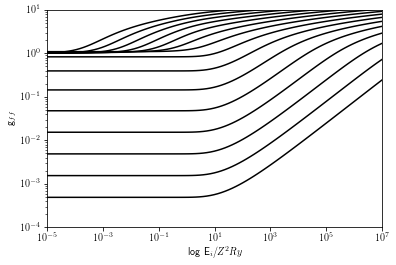

In [217]:
[plt.loglog(energies, gff1[i],'k') for i in range(len(photon_energies))]
plt.xlabel(r'log E_i/Z^2 Ry')
plt.ylabel(r'g_{ff}')
plt.ylim(1e-4,10)
plt.xlim(1e-5,1e7)

In [218]:
Z = 1.0
energies = np.logspace(-5,8,14) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 101) # Ry

gff2 = [[gaunt_free_free(Z, v, photon_energy/2.) for photon_energy in photon_energies] for v in velocities]

(1e-05, 100000000.0)

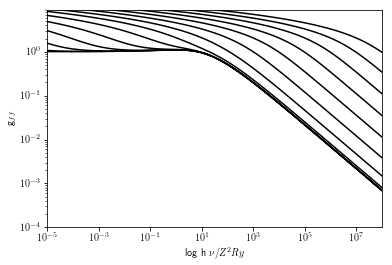

In [219]:
[plt.loglog(photon_energies, gff2[i],'k') for i in range(len(velocities))]
plt.xlabel(r'log h \nu / Z^2 Ry')
plt.ylabel(r'g_{ff}')
plt.ylim(1e-4,9)
plt.xlim(1e-5,1e8)

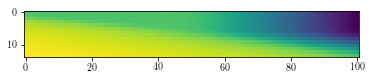

In [227]:
plt.imshow(np.log10(np.asarray(gff2, dtype=float)))

In [32]:
l_nm = np.logspace(-4,2,100)

# Determine energy range.
energies_eV = 1239.8/l_nm
energies_Ha = energies_eV/27.2

Ha_to_eV = 27.2
T = np.logspace(1,5,5)
spectra_eV = [free_free_thermal_spectrum(1.0, t/Ha_to_eV, energies_Ha) for t in T]

### Convert to wavelength spectrum.
spectra_nm = [spectrum_eV / l_nm**2 for spectrum_eV in spectra_eV]
outdata = spectra_nm


/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


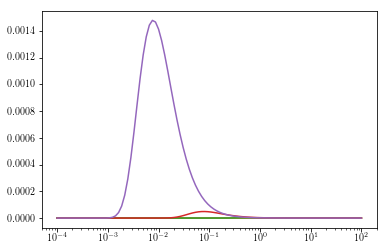

In [33]:
[plt.semilogx(l_nm,spectra_nm[i] ) for i in range(len(spectra_nm))];

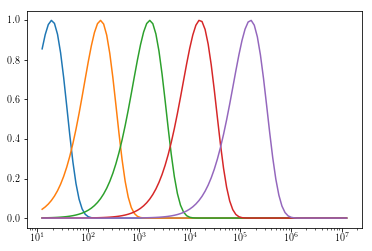

In [34]:
[plt.semilogx(energies_eV,spectra_nm[i]/spectra_nm[i].max() ) for i in range(len(spectra_nm))];

In [175]:
import numpy as np
l_nm1 = np.logspace(-4,2,100)

# Determine energy range.
energies_eV1 = 1239.8/l_nm1
energies_Ha1 = energies_eV1/27.2

Ha_to_eV1 = 27.2
T1 = [4e5]#np.linspace(10,50,41)
spectra_eV1 = [free_free_thermal_spectrum(1.0, t/Ha_to_eV1, energies_Ha1) for t in T1]

### Convert to wavelength spectrum.
spectra_nm1 = [spectrum_eV / l_nm1**2 for spectrum_eV in spectra_eV1]
outdata1 = spectra_nm1


/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


[[<matplotlib.lines.Line2D at 0x11d6b8940>]]

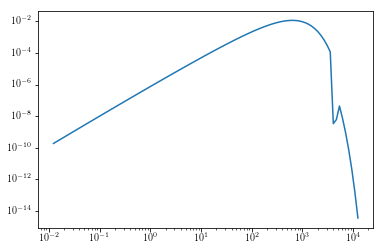

In [178]:
[plt.loglog(energies_eV1/1000,spectra_nm1[i]) for i in range(len(spectra_nm1))]

In [183]:
import functools

In [202]:
def G_l(eta_i, eta_f, k_i, k_f, l, cut=10):
    x = -4.*eta_i*eta_f/(eta_i-eta_f)**2
    if abs(x)< 1:
        g = 0
        for i in range(cut):
            g += a_reg(eta_i, eta_f, l, i) * x ** i
        return g
    else:
        y = -1/x
        A = 0
        B = 0
        lam = (eta_i - eta_f) / 2
        for i in range(cut):
            a,b = continued(eta_i, eta_f, l, i, lam)
            A += a * y ** i 
            B += b * y ** i
        out = y **(l+1) * (np.cos(lam * np.log(y)) * A + np.sin(lam * np.log(y))*B)
        return out
@functools.lru_cache(maxsize=128)    
def a_reg(eta_i, eta_f, l, n):
    if n < 0:
        return 0
    if n == 0:
        return 1
    if n == 1:
        return ((l+1)**2 - eta_i*eta_f)/(2*l + 2)

    aregnminus1 = a_reg(eta_i, eta_f, l, n-1)
    aregnminus2 = a_reg(eta_i, eta_f, l, n-2)
    temp1 = 1/n/(2*l + 1 + n)
    temp2 = aregnminus1*((n-1)*(2*n + 4*l + 1) + (l+1)**2 - eta_i*eta_f)
    temp3 = aregnminus2*((n-2)*(n + 2*l) + (l+1)**2 + eta_i*eta_f/2)**2
    return temp1 * (temp2 - temp3)
@functools.lru_cache(maxsize=128)
def continued(eta_i, eta_f, l, n, lam):
    if n < 0:
        return 0, 0
    if n == 0:
        new = gamma(2*l + 2) * gamma(1j*eta_f - 1j*eta_i) / gamma(l+1-1j*eta_i)/gamma(l + 1 + 1j*eta_f)
        return 2 * new.real, -2*new.imag
    else:
        anminus1, bnminus1 = continued(eta_i, eta_f, l, n-1, lam)
        anminus2, bnminus2 = continued(eta_i, eta_f, l, n-2, lam)
        alpha = l*(l+1) + 2*lam**2 + eta_i*eta_f
        beta = l*(l+1) + lam**2
        
        prefactor = 1 / n/(4*lam**2 + n**2)
        
        tempa = - lam * (3 * n -2+2*alpha)*bnminus1 - lam*(3*n-4+2*beta)*bnminus2
        tempa += (n*alpha - n*(n-1)*(2*n-1) - 2*lam**2*(4*n-3))*anminus1
        tempa += (n*beta - n*(n-1)*(n-2) - 2*lam**2*(2*n-3))*anminus2
        
        tempb = lam * (3 * n -2+2*alpha)*anminus1 + lam*(3*n-4+2*beta)*anminus2
        tempb += (n*alpha - n*(n-1)*(2*n-1) - 2*lam**2*(4*n-3))*bnminus1
        tempb += (n*beta - n*(n-1)*(n-2) - 2*lam**2*(2*n-3))*bnminus2 
        
        return prefactor * tempa, prefactor * tempb

In [127]:
h = constants.value('Planck constant') * 1e7 #in ergs s
c = constants.c * 1.e2 # in cm/s
e_e = 4.80320451e-10 #in statcoulomb
m_e = constants.electron_mass * 1e3 # in g
Ry_in_erg = constants.value('Rydberg constant times hc in J') * 1.e7 #in ergs


In [160]:
def gff_helper(Z, Ei, Ef):
    
    eta_i = Z * (Ry_in_erg / Ei)**.5
    k_i = Z / eta_i / aB_in_cm
    eta_f = Z * (Ry_in_erg / Ef)**.5
    k_f = Z / eta_f / aB_in_cm
    print(eta_i**-2 - eta_f**-2)
    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)
    
    out = 2*3**.5/np.pi/eta_i/eta_f * I0
    out *=((eta_i**2 + eta_f**2 + 2*eta_i**2*eta_f**2)*I0 - 2 * eta_i * eta_f * (1 + eta_i**2)**.5*(1+eta_f**2)**.5*I1)

    return out.real

def gff_emit(Z, beta, E):
    

In [161]:
aB_in_cm = constants.value('Bohr radius')*100.0
print(aB_in_cm)

5.2917721067e-09


In [162]:
gaunt_free_free1(1, Ry_in_erg - h * 1e14, Ry_in_erg)

-0.030396596919959662


mpf('2.4146768611489153')

In [163]:
gaunt_free_free1(1, Ry_in_erg , Ry_in_erg + h * 1e14)

-0.03039659691995955


mpf('2.434515166329962')

$$(Ry/E)^{1/2}a_0 = 1 / k$$

In [ ]:
import scipy.integrate

In [45]:
hb = constants.hbar * 1e7 #in ergs s
c = constants.c * 1.e2 # in cm/s
e_e = 4.80320451e-10 #in statcoulomb
m_e = constants.electron_mass * 1e3 # in g

def gff_ug(x, u, gamma2, Z):
    
    eta_i = (gamma2 / x)**.5
    k_i = Z * m_e * e_e**2 / hb**2 / eta_i
    eta_f = (x / gamma2 + u / gamma2)**(-2)
    k_f = Z * m_e * e_e**2 / hb**2 / eta_f

    if k_i == k_f:
        return 0

    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)
    
    out = 2*3**.5/np.pi/eta_i/eta_f * I0
    out *=((eta_i**2 + eta_f**2 + 2*eta_i**2*eta_f**2)*I0 - 2 * eta_i * eta_f * (1 + eta_i**2)**.5*(1+eta_f**2)**.5*I1)
    return out.real

def gff(u, gamma2, Z):
    return scipy.integrate.quad(lambda x: np.exp(-x) * gff_ug(x, u, gamma2, Z), 0, np.inf)[0]

In [46]:
test = []
for i in np.logspace(-3,3,10):
    test.append(gff(1,i, 1))

/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


NoConvergence: Hypergeometric series converges too slowly. Try increasing maxterms.

In [24]:
np.logspace(-3,3,10)

array([  1.00000000e-03,   4.64158883e-03,   2.15443469e-02,
         1.00000000e-01,   4.64158883e-01,   2.15443469e+00,
         1.00000000e+01,   4.64158883e+01,   2.15443469e+02,
         1.00000000e+03])

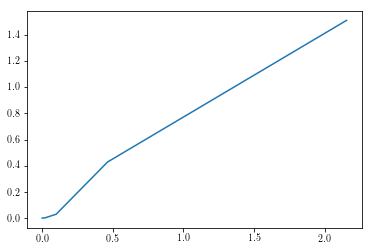

In [47]:
plt.plot(np.logspace(-3,3,10)[:7], test)